In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from matplotlib.patches import Patch
import scipy.io


from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import imputation

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [3]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


In [4]:
sampleSize = 1000
chromosome = ['chr2']
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for i, s in enumerate(sample):
    filetag = "_".join(s.split("_")[0:2]).replace("/", "") + f"_{i}"
    A, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')
    
    # reindex the matrix
    A = A[chrHicInd, :][:, chrHicInd]
    
    # make binary 
    A = np.where(A > 0, 1, 0)
    
    hic[filetag] = A
    
print('done.')
print(f"{len(hic.keys())=}")

done.
len(hic.keys())=1000


In [5]:
for k, v in hic.items():
    assert(v.shape == (182, 182))

In [6]:
reload(imputation)

retain = 0.5

uniformMissing = imputation.randomUniformRemoval(hic, retain=retain)
print(f"{len(uniformMissing.keys())=}")

degreeLimit = imputation.degreeLimitRemoval(hic, retain=retain)
print(f"{len(degreeLimit.keys())=}")

crawlMissing = imputation.breadthFirstRemoval(hic, retain=retain)
print(f"{len(crawlMissing.keys())=}")

coldEnd = imputation.coldEndRemoval(hic, retain=retain)
print(f"{len(coldEnd.keys())=}")

print('done.')

len(uniformMissing.keys())=1000
len(degreeLimit.keys())=1000
len(crawlMissing.keys())=1000
len(coldEnd.keys())=1000
done.


In [7]:
# break

sampleKey='Diploid_35_241'


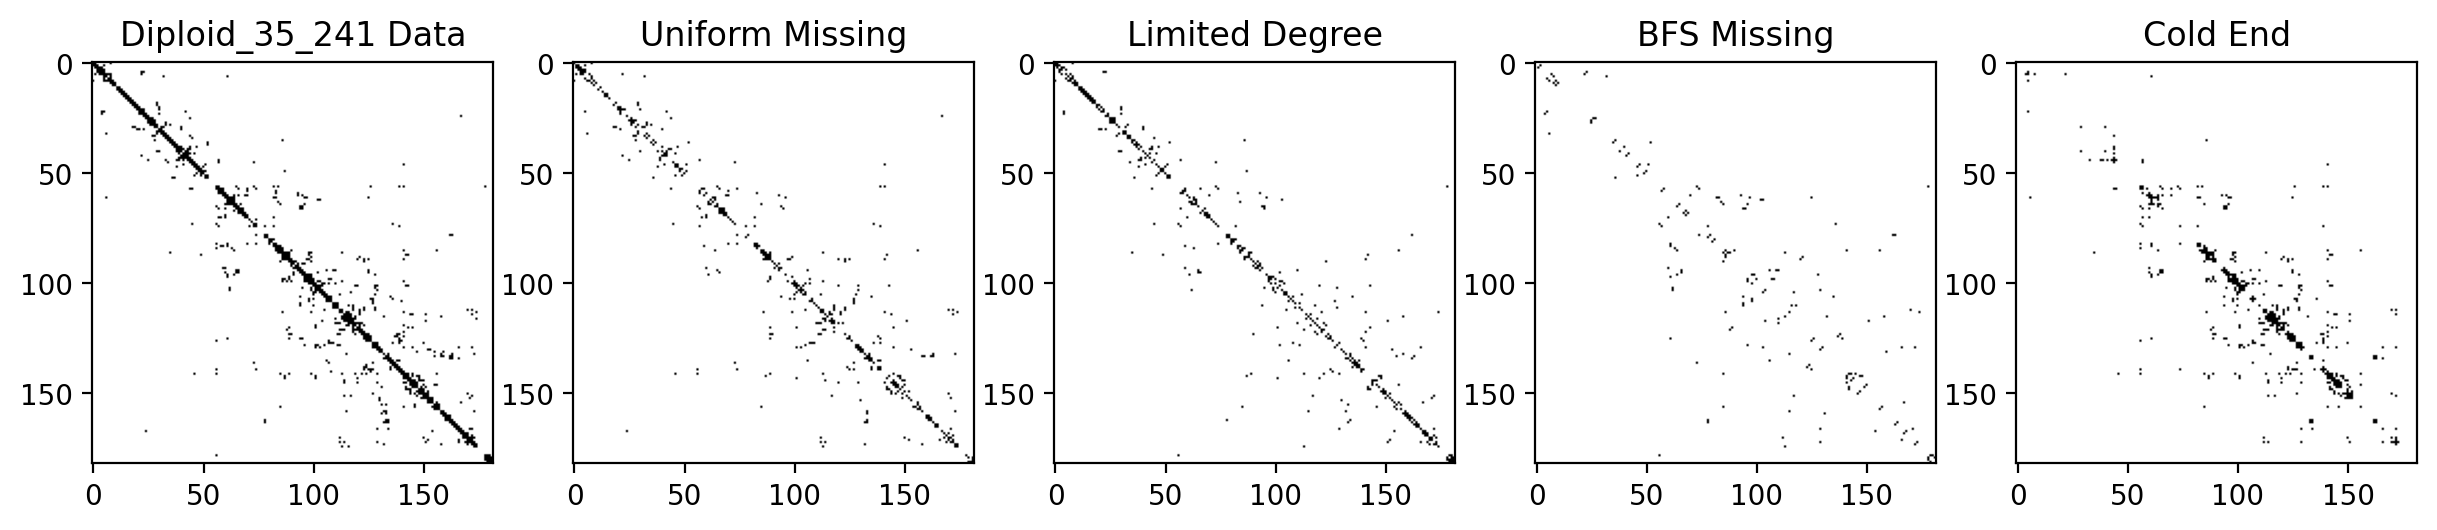

sampleKey='Diploid_5_668'


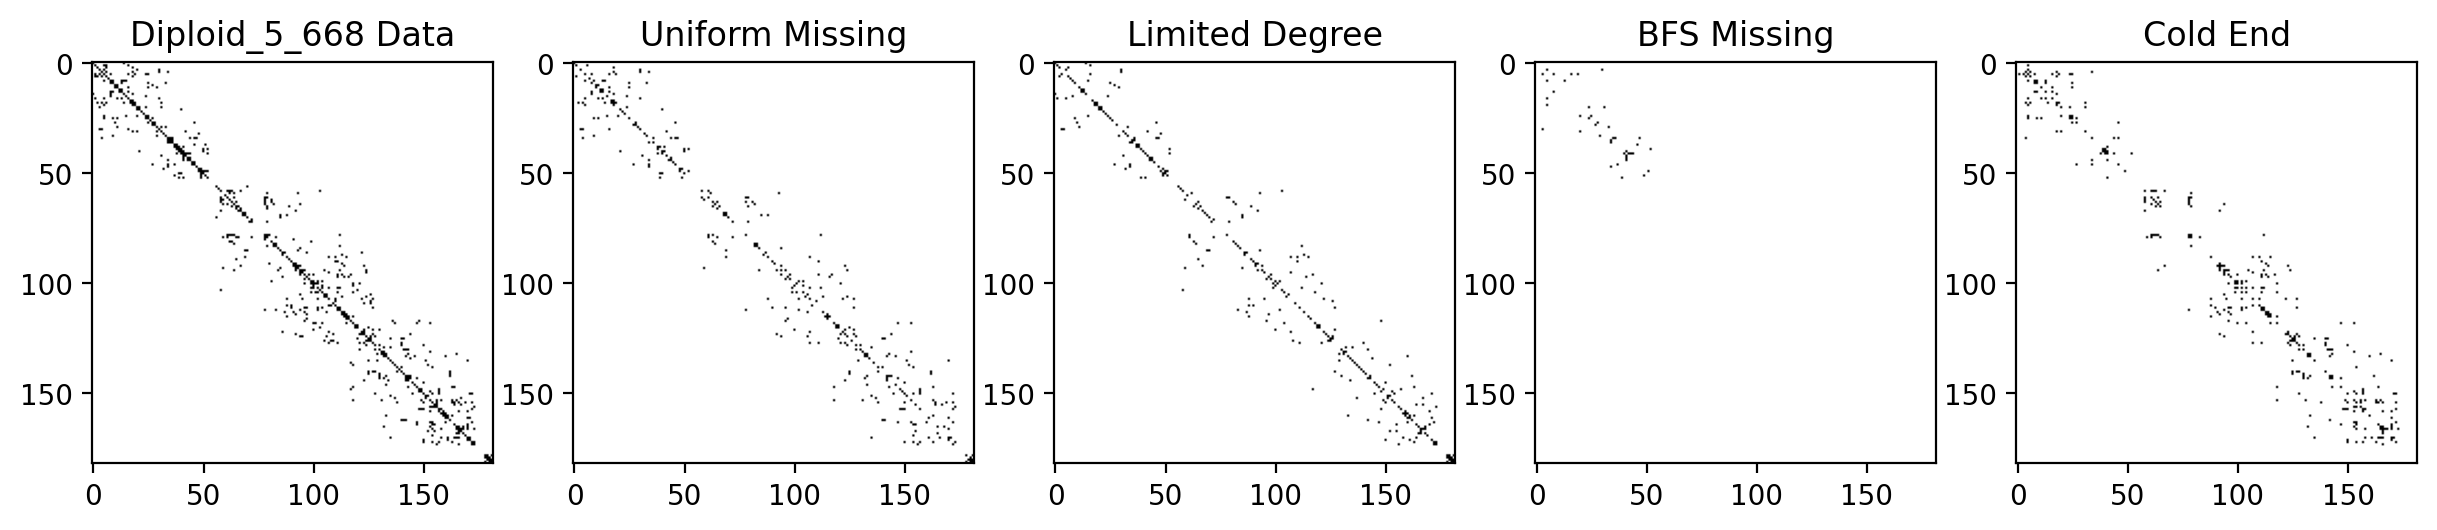

In [8]:
n = 2
sampleKeys = np.random.choice(list(coldEnd.keys()), n)

for sampleKey in sampleKeys:

    print(f"{sampleKey=}")

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 15
    fig = plt.figure()

    fig.add_subplot(151)
    plt.imshow(hic[sampleKey], cmap='binary')
    plt.title(f'{sampleKey} Data')

    fig.add_subplot(152)
    plt.imshow(uniformMissing[sampleKey], cmap='binary')
    plt.title('Uniform Missing')

    fig.add_subplot(153)
    plt.imshow(degreeLimit[sampleKey], cmap='binary')
    plt.title('Limited Degree')

    fig.add_subplot(154)
    plt.imshow(crawlMissing[sampleKey], cmap='binary')
    plt.title('BFS Missing')

    fig.add_subplot(155)
    plt.imshow(coldEnd[sampleKey], cmap='binary')
    plt.title('Cold End')
    
    plt.show()

In [9]:
def imputeResource(A, tau):
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)
    
    pLink = nx.resource_allocation_index(G)
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    if not P.max() == 0:
        P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= tau, 1, 0)
    
    Ap = A + P
    Ap = np.where(Ap > 0, 1, 0)
    return Ap


def imputeCCPA(A, tau):
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)
    
    pLink = nx.common_neighbor_centrality(G, alpha=0.5)
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    if not P.max() == 0:
        P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= tau, 1, 0)
    
    Ap = A + P
    Ap = np.where(Ap > 0, 1, 0)
    return Ap


def imputeAdar(A, tau):
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)
    
    pLink = nx.adamic_adar_index(G)
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    if not P.max() == 0:
        P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= tau, 1, 0)
    
    Ap = A + P
    Ap = np.where(Ap > 0, 1, 0)
    return Ap


def imputePrefAttach(A, tau):
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)
    
    pLink = nx.preferential_attachment(G)
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    if not P.max() == 0:
        P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= tau, 1, 0)
    
    Ap = A + P
    Ap = np.where(Ap > 0, 1, 0)
    return Ap

In [10]:
def evalJaccard(Atrue, Apred):
    return jaccard_score(Atrue.ravel(), Apred.ravel(), zero_division='ignore')

def evalJAUCROC(Atrue, Apred):
    try:
        r = roc_auc_score(Atrue.ravel(), Apred.ravel())
    except ValueError:
        r = 0.5
    return r

In [ ]:
tau = 0.5

missingType = {
    'uniform' : uniformMissing,
    'degreeLimit' : degreeLimit,
    'crawl' : crawlMissing,
    'coldEnd' : coldEnd
}

predictionAlgo = {
    'reallocation' : lambda x : imputeResource(x, tau),
    'CCPA' : lambda x : imputeCCPA(x, tau),
    'adar' : lambda x : imputeAdar(x, tau),
    'preferentialAttach' : lambda x : imputePrefAttach(x, tau),
}

evalMetrics = {
    'jaccard' : evalJaccard,
    'aucroc' : evalJAUCROC,
}


newRows = []

for key in hic.keys():
    
    for algoName, algoFunc in predictionAlgo.items():
        for mTypeName, Adict in missingType.items():
            for evalName, metricFunc in evalMetrics.items():
            
                Apred = algoFunc(Adict[key])
            
                met = metricFunc(hic[key], Apred)

                    
                row = {
                    'cell' : key,
                    'predictionAlgorithm' : algoName,
                    'missingType' : mTypeName,
                    'evalMetric' : evalName,
                    'evalValue' : met,
                    'predMatrix' : Apred,
                    'trainMatrix' : Adict[key],
                    'trueMatrix' : hic[key],
                }
                newRows.append(row)
                
df = pd.DataFrame(newRows)
print(f"{df.shape=}")
df.head()
    

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/

In [ ]:

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5
fig = plt.figure()


    
tmp = df[df['evalMetric'] == 'aucroc']


sns.boxplot(data=df,
            x='missingType',
            hue='predictionAlgorithm',
            y='evalValue')


plt.axhline(y=0.5, ls='--', c='k', label='randomChance')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('AUCROC')


plt.show()
# for mTypeName, Adict in missingType.items():
        
        
        
        
        
        